# Experiments for deep cognitive drone mapping

In [1]:
# =============== Processing graph =====================
#
#                      image
#                        |
#                        | variable name: img
#                        v
#           ---------------------------
#           |mid_level_representations| directly with visualpriors pip install
#           ---------------------------
#                        |
#                        | variable name: mid_level
#                        v
#               ---------------------
#               |  fc ->  decoder   |  content : two functions, fully-connected layer "fc" and decoder resnet "decoder"
#               ---------------------
#                        |
#                        | variable name: map_update
#                        v
#                   -------------        -----------------
#  TODO: Implement  |  combine  |   <--  |   transform   | <--- previous_map
#                   -------------        -----------------
#                        |
#                        | variable name: map
#                        v
#                 ---------------
#  TODO: Implement|   policy    |
#                 ---------------
#                        |
#                        |
#                        v
#                   velocities
#

## Mid-level test

download image to debug...
Passing mid level encoder...


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Done!


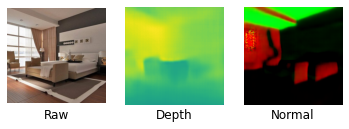

In [31]:
import numpy as np
import matplotlib.pyplot as plt
from experiment import *
image, depth, normal = mid_level()

f, axarr = plt.subplots(1,3) 

axarr[0].imshow(TF.resize(image, 256))
axarr[0].set_axis_off()
axarr[0].set_title("Raw",y=-0.22)

axarr[1].imshow(np.array(depth[0][0]))
axarr[1].set_axis_off()
axarr[1].set_title("Depth",y=-0.2)

axarr[2].imshow(np.array(normal.permute(1,2,0)))
axarr[2].set_axis_off()
axarr[2].set_title("Normal",y=-0.2)
f.savefig("Save Plot as PDF file using savefig.pdf")

In [28]:
np.array(depth[0][0]).shape

(256, 256)

<ipython-input-4-ac58b3dcfdd6>:6: MatplotlibDeprecationWarning: Calling gca() with keyword arguments was deprecated in Matplotlib 3.4. Starting two minor releases later, gca() will take no keyword arguments. The gca() function should only be used to get the current axes, or if no axes exist, create new axes with default keyword arguments. To create a new axes with non-default arguments, use plt.axes() or plt.subplot().
  ax = fig.gca(projection='3d')


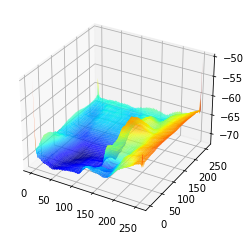

In [4]:
pixgrid = -np.array(depth[0][0])*100

xx, yy = np.mgrid[0:pixgrid.shape[0], 0:pixgrid.shape[1]]

fig = plt.figure()
ax = fig.gca(projection='3d')
ax.plot_surface(xx, yy, pixgrid ,rstride=1, cstride=1, cmap=plt.cm.jet,
        linewidth=0)

plt.show()

## Reshaping functions

download image to debug...
torch.Size([1, 3, 256, 266])
torch.Size([1, 2, 3])
Done!


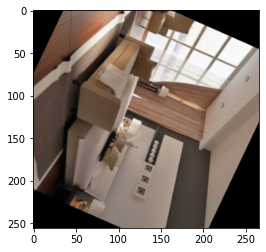

In [4]:
from experiment import *
import matplotlib.pyplot as plt

cogmap, transformed_map = test_geom_transform(0,.2,2)
plt.imshow(transformed_map[0,:,:].permute(1,2,0))

# Testing the mid level function

In [6]:
from config import *
from PIL import Image
from networks.encoder_mid_level import mid_level_representations
from networks.fc import FC
import torchvision.transforms.functional as TF

from networks.decoder_residual import UpResNet
import config 

image = Image.open('test.png')
img = TF.to_tensor(TF.resize(image, 256)) * 2 - 1
img = img.unsqueeze(0)                              # (1,3,256,256)
img = img.repeat(BATCHSIZE, 1, 1, 1)                # (BATCHSIZE x 3 x 256 x 256) tensor


#==========Mid level encoder==========
print("Passing mid level encoder...")
mid_level=mid_level_representations(img,REPRESENTATION_NAMES)

print(mid_level.size()    )

mid_level_flat = mid_level.view(BATCHSIZE,-1)
mid_level_flat.size()

fc = FC()   

post_fc = fc(mid_level_flat)
print(post_fc.size())

concat = post_fc.view(BATCHSIZE,8*2,16,16)

print(concat.size())

decoder = UpResNet(layers=RESIDUAL_LAYERS_PER_BLOCK,channels=RESIDUAL_NEURON_CHANNEL,strides=STRIDES,sizes = RESIDUAL_SIZE).to(DEVICE)


map_update = decoder(concat)

print(map_update.size())

Passing mid level encoder...
torch.Size([4, 16, 16, 16])
torch.Size([4, 4096])
torch.Size([4, 16, 16, 16])
built net
torch.Size([4, 2, 256, 256])


torch.Size([4, 2, 256, 256])


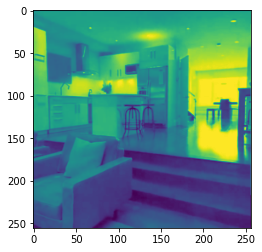

In [7]:
import matplotlib.pyplot as plt
prev_map_raw = Image.open('Bedroom.jpg') #example prevmap value
prev_map = TF.to_tensor(TF.resize(image, 256))[0:2] * 2 - 1
prev_map = prev_map.unsqueeze(0)
plt.imshow(prev_map[0,0,:,:])
prev_map = prev_map.repeat(BATCHSIZE, 1, 1, 1)
print(prev_map.shape)

In [8]:
import matplotlib.pyplot as plt
prev_confmap = prev_map[:,0,:,:]
update_confmap = map_update[:,0,:,:]
total_conf = torch.add(prev_confmap,update_confmap)
print(total_conf.shape)

torch.Size([4, 256, 256])
